In [1]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
twitter_data=pd.read_csv('/content/Twitter_Data.csv')
twitter_data.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [4]:
twitter_data.shape
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147473 entries, 0 to 147472
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  147472 non-null  object 
 1   category    147471 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.3+ MB


In [5]:
twitter_data['category'].value_counts()

 1.0    65239
 0.0    49948
-1.0    32284
Name: category, dtype: int64

In [6]:
labels = pd.get_dummies(twitter_data.category)
labels.columns = ["negative", "neutral", "positive"]
labels.head()

,negative,neutral,positive
0,1,0,0
1,0,1,0
2,0,0,1
3,0,0,1
4,0,0,1


<Axes: xlabel='category', ylabel='count'>

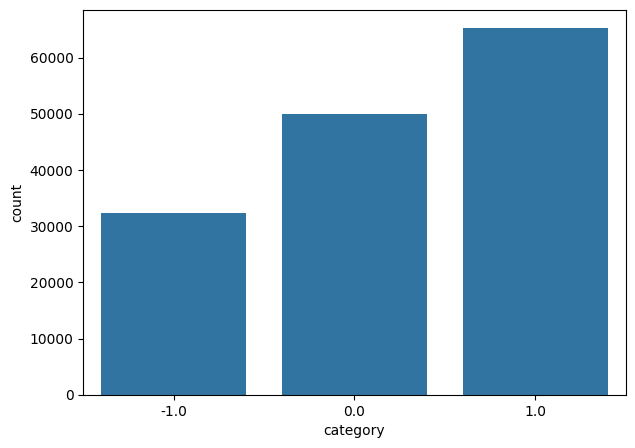

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(7,5))
sns.countplot(x="category",data=twitter_data)


Text(0.5, 1.0, 'Distribution of sentiments')

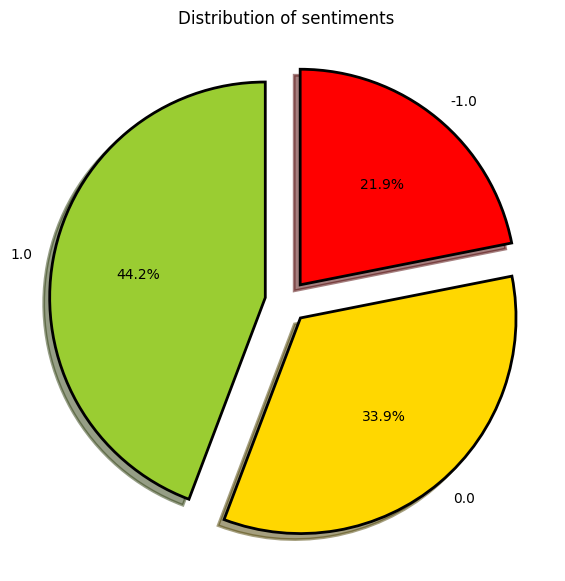

In [8]:
fig = plt.figure(figsize=(7,7))
colors = ("yellowgreen", "gold", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = twitter_data['category'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

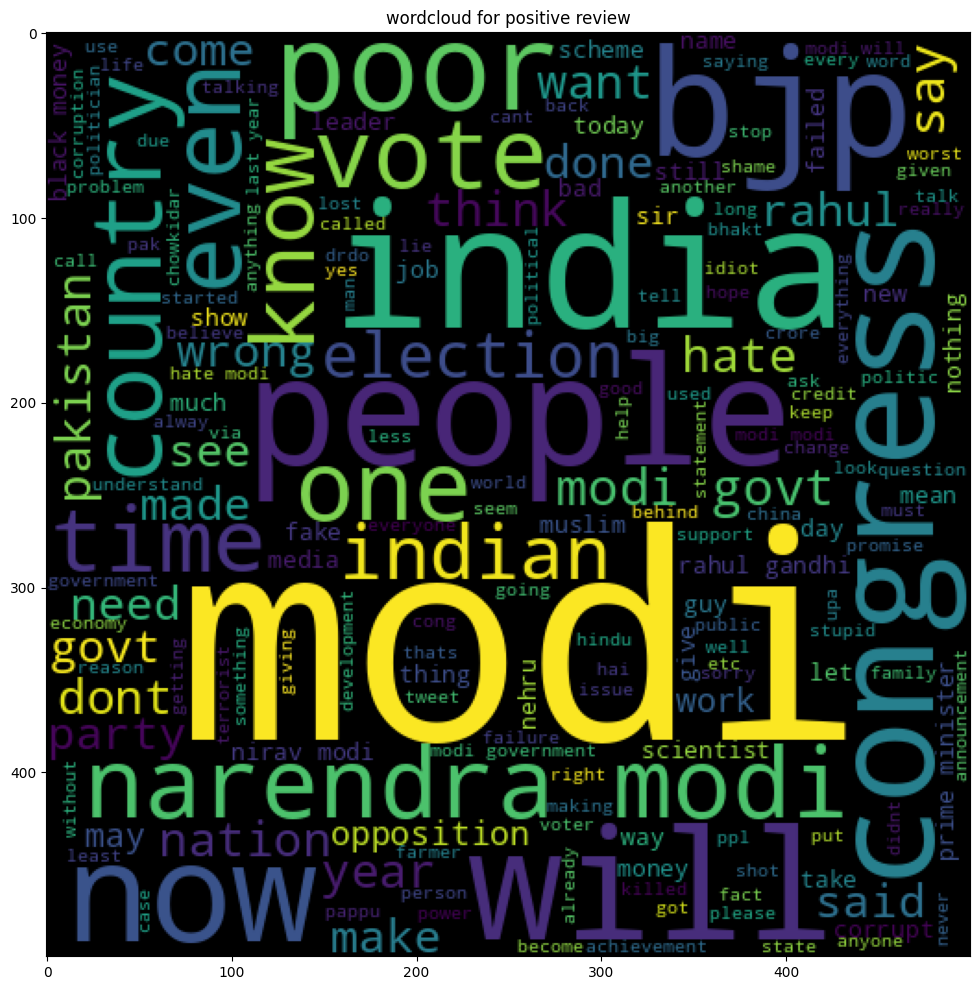

In [9]:
from wordcloud import WordCloud
wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = 'black')
positive_wc = wc.generate(twitter_data[twitter_data['category'] == 1.0]['clean_text'].str.cat(sep = " "))
neutral_wc = wc.generate(twitter_data[twitter_data['category'] == 0.0]['clean_text'].str.cat(sep = " "))
negative_wc = wc.generate(twitter_data[twitter_data['category'] == -1.0]['clean_text'].str.cat(sep = " "))
plt.figure(figsize = (12, 12))
plt.title('wordcloud for positive review')
plt.imshow(positive_wc)

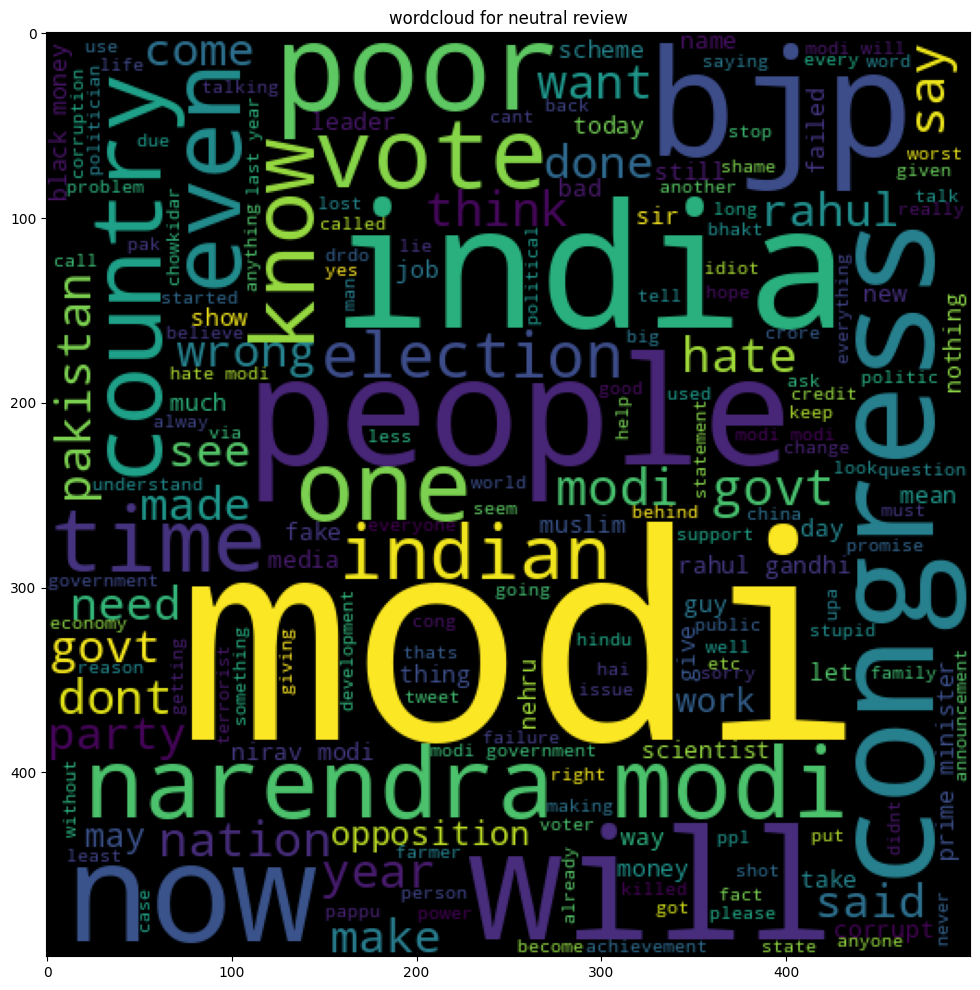

In [10]:
plt.figure(figsize = (12, 12))
plt.title('wordcloud for neutral review')
plt.imshow(neutral_wc)

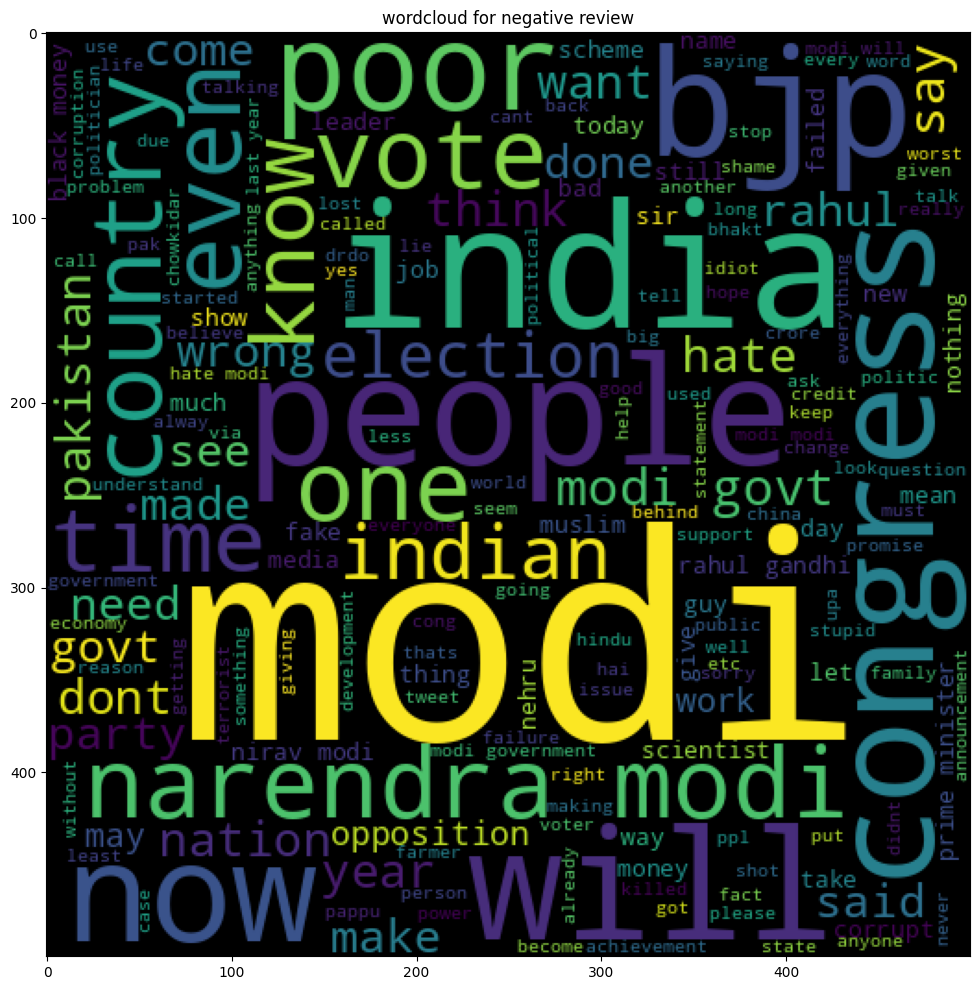

In [11]:
plt.figure(figsize = (12, 12))
plt.title('wordcloud for negative review')
plt.imshow(negative_wc)

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,  ConfusionMatrixDisplay

In [13]:
X = twitter_data['clean_text'].values.astype('U')
y = twitter_data['category'].values.astype('U')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y)

In [14]:
pipe = Pipeline([('tfidf_vectorizer',TfidfVectorizer(lowercase = True, stop_words = 'english',analyzer = 'word')), ('naive_bayes', MultinomialNB())])
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

pipe.fit(list(X_train), list(y_train))
y_pred = pipe.predict(X_test)
print(confusion_matrix(y_pred, y_test))
print(accuracy_score(y_pred, y_test))
pipe['naive_bayes']

[[ 1246    37    57     0]
 [  417  5139   526     0]
 [ 8022  9808 18989     1]
 [    0     0     0     0]]
0.5735274173861941


MultinomialNB()

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X_sequences = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_sequences)
X_train_seq, X_test_seq, y_train, y_test = train_test_split(X_padded, labels, test_size=0.3, stratify=labels)

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=X_padded.shape[1]),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dense(3, activation='softmax')  # Assuming 3 classes: negative, neutral, positive
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [18]:
model.fit(X_train_seq, y_train, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
1291/1291 [==============================] - 462s 356ms/step - loss: 0.3434 - accuracy: 0.8727 - val_loss: 0.1698 - val_accuracy: 0.9483
Epoch 2/5
1291/1291 [==============================] - 452s 350ms/step - loss: 0.1067 - accuracy: 0.9675 - val_loss: 0.1306 - val_accuracy: 0.9590
Epoch 3/5
1291/1291 [==============================] - 462s 358ms/step - loss: 0.0552 - accuracy: 0.9828 - val_loss: 0.1260 - val_accuracy: 0.9636
Epoch 4/5
1291/1291 [==============================] - 453s 351ms/step - loss: 0.0325 - accuracy: 0.9896 - val_loss: 0.1687 - val_accuracy: 0.9583
Epoch 5/5
1291/1291 [==============================] - 453s 351ms/step - loss: 0.0197 - accuracy: 0.9939 - val_loss: 0.1797 - val_accuracy: 0.9558


In [19]:
loss, accuracy = model.evaluate(X_test_seq, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

1383/1383 [==============================] - 35s 25ms/step - loss: 0.1783 - accuracy: 0.9567
Test Loss: 0.17825940251350403, Test Accuracy: 0.9567153453826904


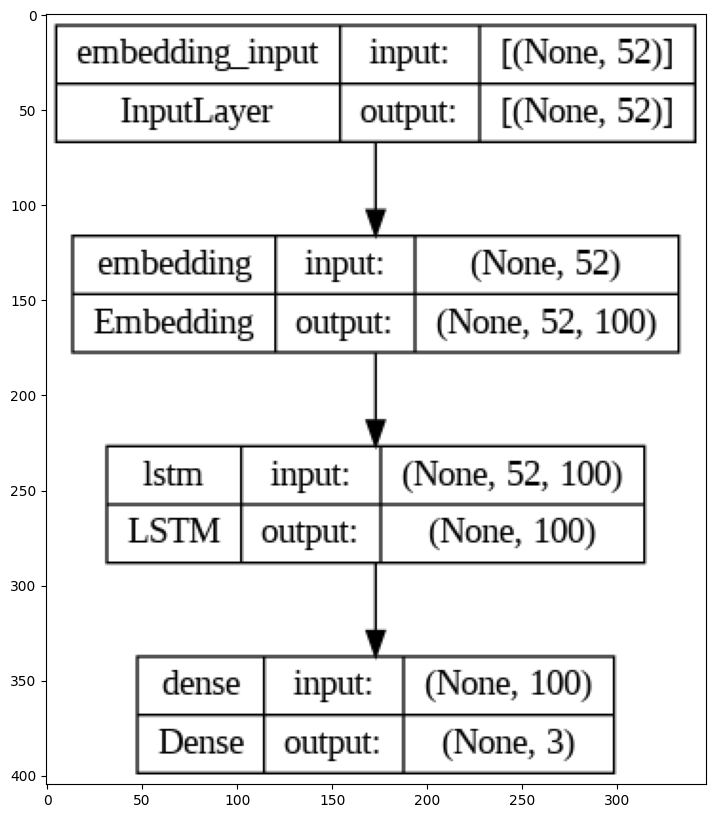

In [20]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Display the plot
img = plt.imread('model_architecture.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()